In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


Matplotlib is building the font cache; this may take a moment.


In [ ]:

df = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")


<ipython-input-2-2e6b0802d97c>:2: DtypeWarning: Columns (42,174,175,178,179,182,183,188,189,203,204,205,231,232,233,238,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")


In [ ]:
# Filter to passing plays and define X/y
pass_df = df[df['play_type'] == 'pass']

input_features = pass_df[[
    'quarter_seconds_remaining', 'down', 'ydstogo', 'yardline_100',
    'pass_length', 'score_differential', 'qb_scramble', 'shotgun', 'no_huddle',
    'qtr', 'posteam_score', 'defteam_score', 'goal_to_go'
]].dropna()

target_features = pass_df.loc[input_features.index, 'pass_touchdown']


In [ ]:
# Preprocessing pipeline
categorical_cols = ['pass_length', 'qtr', 'goal_to_go']
numeric_cols     = [c for c in input_features.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(),             numeric_cols),
    ('cat', OneHotEncoder(drop='first'),  categorical_cols)
])

X_processed = preprocessor.fit_transform(input_features)

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, target_features,
    test_size=0.20,
    random_state=513,
    stratify=target_features
)


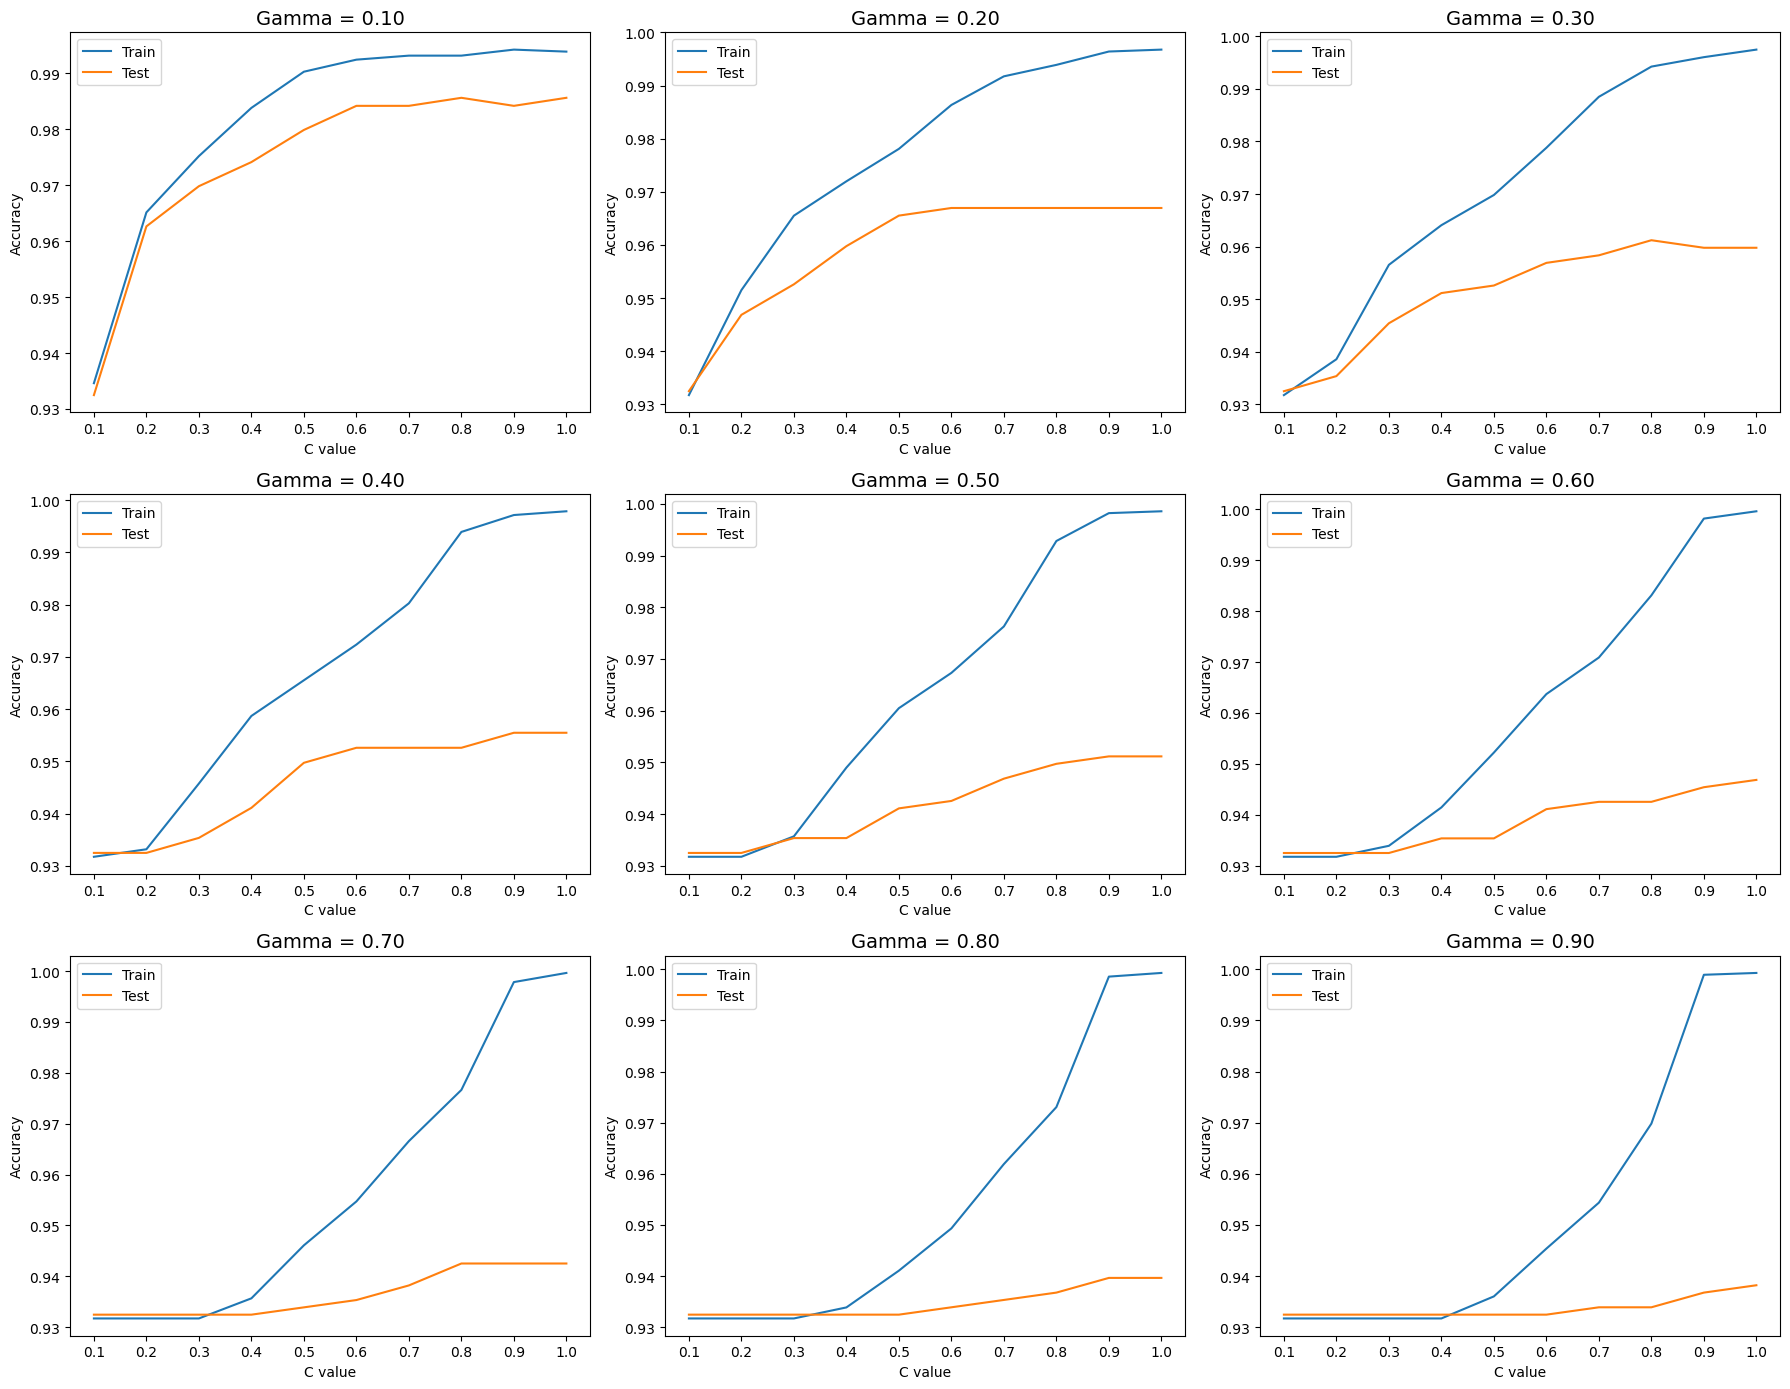

In [ ]:
# Hyperparameter exploration: vary γ (outer) and C (inner)
C_range     = np.arange(0.1, 1.1, 0.1)
gamma_range = np.arange(0.1, 1.0, 0.1)

fig = plt.figure(figsize=(18, 14))
idx = 1

for gamma in gamma_range:
    train_scores = []
    test_scores  = []
    for C in C_range:
        svc = SVC(C=C, kernel='rbf', gamma=gamma)
        svc.fit(X_train, y_train)
        train_scores.append(svc.score(X_train, y_train))
        test_scores.append(svc.score(X_test, y_test))

    ax = fig.add_subplot(3, 3, idx)
    ax.plot(C_range, train_scores, label='Train')
    ax.plot(C_range, test_scores,  label='Test')
    ax.set_title(f"Gamma = {gamma:.2f}", size=14)
    ax.set_xlabel("C value")
    ax.set_ylabel("Accuracy")
    ax.set_xticks(C_range)
    ax.legend()
    idx += 1

plt.tight_layout()
plt.show()


In [ ]:
# Train final SVM model
final_model = SVC(C=0.5, kernel='rbf', gamma=0.3, probability=True)
final_model.fit(X_train, y_train)


SVC(C=0.5, gamma=0.3, probability=True)

In [ ]:
# Evaluate
y_pred = final_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9525862068965517
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       649
         1.0       1.00      0.30      0.46        47

    accuracy                           0.95       696
   macro avg       0.98      0.65      0.72       696
weighted avg       0.95      0.95      0.94       696



In [ ]:
# Prepare a new play for prediction (aligned with model features)
new_play = pd.DataFrame({
    'quarter_seconds_remaining': [893],
    'down': [1],
    'ydstogo': [10],
    'yardline_100': [13],
    'pass_length': ['short'],
    'score_differential': [0],
    'qb_scramble': [0],
    'shotgun': [0],
    'no_huddle': [0],
    'qtr': [1],
    'posteam_score': [0],
    'defteam_score': [0],
    'goal_to_go': [False]
})


In [ ]:
# Transform & predict
X_new_proc = preprocessor.transform(new_play)
print("Predicted pass touchdown (0=no, 1=yes):", final_model.predict(X_new_proc)[0])


Predicted pass touchdown (0=no, 1=yes): 0.0
